# Natural Language Processings of Bookings.com Hotel Reviews - Modeling

Pippi de Bree

## Table of Contents 
#### [Introduction](#Intro)
#### [Library and Imports](#Imports)
#### [Dataset Exploration](#Explo)
#### [Linear Classifier](#Linear)
#### [K-Nearest Neighbours Classifier](#KNN)
#### [Decision Tree Classifier](#Tree)
#### [Why do we Validate?](#Valid)
#### [Cross Validating A Logistic Regression Classifier](#Cross)
#### [New Feature Creation](#Feature)
#### [Conclusion](#Conclu)

# Introduction <a id=Intro a>

Now that we have transformed our data to a workable format, we can begin building a model to predict whether a reviewer gave a good review or not. In our exploration of the features in the NLP dataset we transformed the `Reviewer_Score` variable to a binary variable. In this iteration of the dataset the new variable is called `good_review`, and is a measure of whether a review is good or bad. (Created by categorizing reviews 8.5 and above as ‘1’ for good and all other ‘Reviewer_Score’ values as ‘0’). 

Vectorizing the reviews in the Feature Engineering part of this project resulted in a large number of word, or lemma, attributes. These were not removed so that in our modeling the importance of specific variables could be considered. 

In order to predict the goodness of reviews, we will explore using Logisitc Regression, K Nearest Neighbours and Decision Tree Classifiers. These algorithms are based in categorizing data points into classes. For our problem we only have two classes a 'good' rating (encoded as 1) and a 'bad' rating (encoded as 0). Therefore, we will only be performing a binary classification. 

# Library and Imports <a id=Imports a>

In order to begin our modelling we need to import some packages and libraries that will allow us to easily work with our data and execute our models. 



In [245]:
# Data Manipulation Libraries
import numpy as np 
import pandas as pd

# Math/Statistical Analysis Libraries 
import math 
from scipy import stats

# The time function will let us consider the run time of our models.
import time 

It is also important to have access to visualisation libraries, so that we can easily interpret our findings. The code below imports standard libraries. 

In [246]:
# seaborn and variables matplotlib packages are used for visualiations.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Setting plot figure size (uses these settings every time you run the plot code).
plt.rcParams['figure.figsize'] = (8.0, 8.0)

The main package we will be using for this modelling is [sklearn](#https://scikit-learn.org/stable/modules/classes.html). This package allows us to implement a variety of classification models and the cross functionality will make it easy for us to iterate over models in order to find the best fit. As this library is vast, we will only import functions as needed. Below we 

In [247]:
# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Dimensionality Reduction 
from sklearn.decomposition import PCA

from sklearn.utils import resample


# Modelling 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Parameter Optimisation Search
from sklearn.model_selection import GridSearchCV

# Evaluation 
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

Finally, we will import a custom utility library, named `ds_utils` that will give us access to pre-written functions that may be helpful in our exploration and modelling.

In [248]:
import ds_utils
import hotel_nlp

Now that we have our packages loaded, we can begin by looking into our data. 

# Dataset Exploration <a id=Explo a>

To start, we need to read in our data. From the given data we can see that the data is already split into a training and a testing set. We will read these into separate pandas dataframes, using the `read_csv_pd` function from the utils library. We will start with the training data.

In [249]:
# Train dataset read-in 
hr_train = ds_utils.read_csv_pd('data/Reviews_Train.csv')
hr_train.head()

The DataFrame contains 37674 rows and 1115 columns.
There are 0 missing values and 0 duplicated rows.


,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,lat,lng,frequent_reviewer,uk_reviewer,usa_reviewer,...,n_without,n_woke,n_work,n_worn,n_worst,n_worth,n_would,n_wrong,n_year,n_yet
0,142,8.4,21,1781,2,48.204183,16.372666,1,1,0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,398,7.9,64,1521,2,51.526662,-0.129657,0,1,0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,417,6.7,9,2400,7,51.512450,-0.179522,0,1,0,...,0.0,0.0,0.57577,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,1058,7.7,24,4380,5,51.514218,-0.180903,1,0,0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,193,7.5,64,587,49,51.603207,0.010607,1,1,0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.14849,0.0,0.0,0.0


We can now read-in our testing set. 

In [250]:
hr_test = ds_utils.read_csv_pd('data/Reviews_Test.csv')
hr_test.head()

The DataFrame contains 12390 rows and 1115 columns.
There are 0 missing values and 0 duplicated rows.


,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,lat,lng,frequent_reviewer,uk_reviewer,usa_reviewer,...,n_without,n_woke,n_work,n_worn,n_worst,n_worth,n_would,n_wrong,n_year,n_yet
0,48,7.7,16,684,18,48.860348,2.344053,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,617,8.8,14,2213,16,51.502702,-0.188216,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,8.4,8,1538,0,48.200287,16.354775,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,224,8.4,7,845,18,51.519616,-0.121843,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,141,8.9,9,1444,16,48.881442,2.323559,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Again, it seems that we have correctly read in our data. However, a bit more inspection into the compatability of our training and testing sets is necessary. As we have two separate dataframes we need to ensure that they have the same number of columns and that the datatypes match. Though, in theory, we should not touch our test set we need to ensure that it will be compatible with a model that has been developed with our training set. 

We will start by making sure that the columns are exactly the same, to do this we will compare the arrays in which the column names are stored. Using the `np.array_equal` function will test this for us. We will use a similar technique to inspect whether the datatypes of these columns also match. 

In [251]:
# Checking the columns of the dataset match 
print("The Columns names are the same:", np.array_equal(hr_train.columns, hr_test.columns))
print("The Column datatypes are the same:", np.array_equal(hr_train.dtypes.values, 
                                                          hr_test.dtypes.values))

The Columns names are the same: True
The Column datatypes are the same: True


This result is encouraging. We will look at little more deeply into these columns, from above we know that there are 1118 columns to consider. Given that we know that some vectorisation has been performed we will look into separating these to look more deeply at their values. 

We know that the words for positive review are labeled with a 'p_' and those from negative review are labeled with a 'n_'. We will separate these and count how many there are, and how many are not part of these groups.

In [252]:
print('Number of attributes from the Positive review vectorisation:',
      len(hr_train.columns[hr_train.columns.str.startswith('p_')]))
print('Number of attributes from the Negative review vectorisation:',
      len(hr_train.columns[hr_train.columns.str.startswith('n_')]))
print('Number of attributes not from vectorisation:', 
      len(hr_train.columns[hr_train.columns.str.startswith(('p_','n_')) == False]))

Number of attributes from the Positive review vectorisation: 463
Number of attributes from the Negative review vectorisation: 619
Number of attributes not from vectorisation: 33


From this we can see that there are more attributes from the negative review vectorisation than the positive. As we are going to reduce the size of these attribute sets to what is relevant, we will keep on with this number of variables.

In [253]:
hr_train[hr_train.columns[hr_train.columns.str.startswith(('p_','n_')) == False]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37674 entries, 0 to 37673
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Additional_Number_of_Scoring       37674 non-null  int64  
 1   Average_Score                      37674 non-null  float64
 2   Review_Total_Negative_Word_Counts  37674 non-null  int64  
 3   Total_Number_of_Reviews            37674 non-null  int64  
 4   Review_Total_Positive_Word_Counts  37674 non-null  int64  
 5   lat                                37674 non-null  float64
 6   lng                                37674 non-null  float64
 7   frequent_reviewer                  37674 non-null  int64  
 8   uk_reviewer                        37674 non-null  int64  
 9   usa_reviewer                       37674 non-null  int64  
 10  Leisure_trip                       37674 non-null  int64  
 11  Submitted_from_a_mobile_device     37674 non-null  int

Now we will look at the proportions of the data in the vectorised sets. Many attributes came from these vectorisations but we expect to see mant variables with low positive indicators for the specific word. As mentioned, it is good practice at this point to remove all variables with less than 5% useful data (so less than 5% '1' values for our encoded words). To do this we will look at the mean values for the columns.

In [254]:
hr_train[hr_train.columns[hr_train.columns.str.startswith(('p_','n_'))]].mean().sort_values(ascending=False)
#mean_for_vects

p_locat     0.111416
p_staff     0.076550
n_room      0.063499
p_room      0.062452
p_good      0.057362
              ...   
n_situat    0.000730
n_email     0.000722
n_anyon     0.000721
n_guy       0.000689
n_apolog    0.000668
Length: 1082, dtype: float64

We have an unexpected outcome here. Firstly, we did not expect to see empty string encoded values (`p_` and `n_`). The second surprise is that these have means higher than 1. If they were correctly encoded these columns would only include values between 0 and 1. We will definitely drop these. 

Next, we will drop columns where the mean is less than 5%, meaning less than 5% useful data. 

In [255]:
vect_cols = hr_train[hr_train.columns[hr_train.columns.str.startswith(('p_','n_'))]]
mean_for_vects = (vect_cols != 0).mean().sort_values(ascending=False)

In [256]:
unuseful_vects = mean_for_vects.loc[mean_for_vects < 0.05].index.values
useful_vects = mean_for_vects.loc[mean_for_vects >= 0.05].index.values
print("Number of unuseful vectoriser attributes:",len(unuseful_vects))
print("Number of useful vectoriser attributes:",len(useful_vects))

Number of unuseful vectoriser attributes: 1051
Number of useful vectoriser attributes: 31


In [257]:
useful_vects

array(['p_locat', 'p_staff', 'n_room', 'p_room', 'p_hotel', 'p_good',
       'p_great', 'p_friendli', 'p_help', 'p_breakfast', 'p_clean',
       'n_hotel', 'p_comfort', 'p_nice', 'p_bed', 'p_excel',
       'n_breakfast', 'n_small', 'p_love', 'n_staff', 'p_stay', 'n_noth',
       'n_bed', 'p_station', 'n_could', 'p_close', 'n_would', 'p_walk',
       'n_bathroom', 'n_bit', 'n_one'], dtype=object)

We end up dropping 2283 values and having 31 usable vectorisation attributes. We will access these later, in order to test dimensionality reduction, so we will bear these in mind but not drop them yet, entirely. 

Finally, we will look at our `good_review` column to see what proportion of the training set is marked as a good review. Through our downsampling, we expect that this remains around 50%.

In [258]:
hr_train['good_review'].describe()

count    37674.000000
mean         0.500000
std          0.500007
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: good_review, dtype: float64

We can see that a good proportion of the training dataset is marked as 'bad' reviews - 50%, matching our expectation. This is a fairly good split but it is important that our training sets both has an equal numbers of 'good' and 'bad' distinctions. If our classes are not equal, we face the issue of our model being built biased towards one of the groups. (This is only an issue in our training set, as our test set does not impact our model build and should be not be tinkered with).

As we have equal classes we only need to reformat the so that it is in `X_train`, `y_train`, `X_test` and `y_test` sets. Creating these splits into X and y is necessary in order to use the sklearn modeling algorithms. However, we will need to further split our training set into a validation set, as we are going to explicitly validate (as well as within a cross validation grid search).

In [259]:
# Creating our X and y from our training set means isolating the 'good_review' column 
y_train_full = hr_train['good_review']
X_train_full = hr_train.drop(columns=['good_review'])

# Repeating same process with testing set
y_test = hr_test['good_review']
X_test = hr_test.drop(columns=['good_review']) 

We will also create a version of our dataframe without the attributes from the vectorisations that have less than 5% useful data, by using the `useful_vects` attributes. We will use this as our main dataset, but there are instances where we want to use the full dataset to see how different methods optimise dimensionality.

In [260]:
X_train_useful_full = X_train_full.drop(columns=unuseful_vects)
X_test_useful = X_test.drop(columns=unuseful_vects)

As a final step it is helpful to know the proportion of the total data that will be used in training.

In [261]:
print(round(len(X_test)/(len(X_test) + len(X_train_full)), 4))

0.2475


We have an about 25% of our data in the test set and are now ready to start modelling! 

As a note, because we already have a split in our data we will be utilising sklearn's `train_test_split` in order to get our validation dataset (this is only true before we begin implementing `cross_val_score`). Though called, train_test_split, the resulting 'test' set will be, in reality, the validation set. Once our models are built and selected, we will use the real test set to evaluate the success of our classifiers. The `hotel_nlp` function `train_test_downsample` will be re-used here to create the new training and validation sets. 

In [262]:
X_train_sub, y_train_sub, X_val, y_val = hotel_nlp.train_test_downsample(hr_train)

Before Downsampling:
Number of negative 'good_review' values in training set: 14649
Number of positive 'good_review' values in training set: 14736

After Downsampling:
Number of negative 'good_review' values in training set: 14649
Number of positive 'good_review' values in training set: 14649

Test Size: 8289
Train Size: 29298
Total Sample Size: 37587 (proportionally: 0.07)
New Train/Test Split Proportion: 0.221


We will also create these sets with only the useful vectorised values.

In [263]:
X_train_sub_useful = X_train_sub.drop(columns=unuseful_vects)
X_val_useful = X_val.drop(columns=unuseful_vects)

Before we start modelling we will intiate a dataframe to keep track of our selected models. It will be called `model_comp` and has the columns: 

In [264]:
model_comp = pd.DataFrame(
    columns=['model','parameters','train_score','test_score',
             'vectoriser','number of features'])

# Linear Classifier - Logistic Regression <a id=Linear a>

We will begin our predictions of `good_review` using a Logistic Regression model. This model is based in calculating the probability of a data point being in one of two classes. Then the data point is assigned to the category based on whether it reaches a decided probability threshold - if it does not, it is assigned to the other category. Though it is based in a binary decision, it can be applied to multiple classification problems. Multiple logistic regressions are run and data points are assigned to the category with the highest corresponding probability.

To start, we will run a base model in order to understand how well a Logistic Regression performs without any dimensionality reduction. Given that we will want to interpret the size of regression coefficients in order to see which attributes are most impactful, we need to scale. This is so that the values of the coefficients reflect attributes that have the same units, if there were different units we could not compare their size. It is assumed that a StandardScaler will be best suited to this data because it accouts for variation, so we will only use this . We will also check the viability of a MinMaxScaler, which ensures that all values lie between 0 and 1. However the normality of the StandardScaler (mean at 0 and standard deviation of 1) give it a better representation of the distribution of the data. 

The C parameter is a measure of the weights placed on large coefficient values. This is part of Regularisation, where the optimization problem of logistic regression is altered so that less weight is put on extreme coefficient values (which could cause overfitting). Practically, Regularisation is done for Logistic Regressions by either using a Lasso Regression or a Ridge Regression. For a Lasso Regression, weights are penalised equally, but for a Ridge Regression big coefficients are penalised more. As the lbfgs sovler only allows for l2 penalty, we will not implement a Lasso Regression (l1). This means that none of our coefficients will be driven to zero, as can happen with Lasso. As the default solver is 'l2' (Ridge Regression) and the default solver is 'lbfgs' we do not need to pass these into our model intiations. We will however, pass in a variety of values for C, (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000 and 10000) in order to see how the different penalty strengths will impact the model. C is the inverse of the regularisation strength, meaning a large value will have smaller regularisation impacts. 

As we are going to look at three scalers and 8 different possible values for c, we will be considering 20 different pipelines (based on trying two different types of scalars). 

In order to look into these different combinations, we will implement a function written to iterate over multiple logistic regressions, but with different parameters. This is done by using a pipeline and inputting specific combinations of parameters. The result of the function is a dataframe with information on the parameters used and the training and testing score.

In [266]:
def log_pipe(X_train, X_test, y_train, y_test, scalers, C_vals):
    """
    Takes in data and a set of parameters for a logistic regression and then runs 
    all combinations of the paramters. Training and testing scores are reported, along 
    with individual model parameters, in a dataframe (which is the value returned by the
    function)."""
    
    # initialising dataframe for model comparison
    lr_mods = pd.DataFrame(columns=[
        'model', 'scaler', 'C', 'train_score', 'test_score'
    ])
    
    # looping through scaling options
    for s in scalers:
        # looping through c options
        for c in C_vals:
            
            # initialising estimators with specific combination of parameters
            lr_estimators = [('scale', s),
                            ('model', LogisticRegression(C = c,
                                                        solver='lbfgs', 
                                                        max_iter=2000))]
             
            # intialising pipeline with specific parameters
            lr_pipe = Pipeline(lr_estimators)
            
            # fitting our pipeline
            lr_pipe.fit(X_train, y_train)
            
            # adding data and scores to our model comparison dataframe
            lr_mods = pd.concat([lr_mods,pd.DataFrame({
                'model': [lr_pipe[-1]],
                'scaler': [s], 
                'C': [c], 
                'train_score': [lr_pipe.score(X_train, y_train)],
                'test_score': [lr_pipe.score(X_test, y_test)]})])
    
    # return model comparison dataframe
    return lr_mods

We will start by using the above `log_pipe` function but with the default parameters for sklearn's Logistic Regression. However, we will include a scaling, using a StandardScaler. The default parameters are penalty= l2, C=1 and solver = lbfgs.

In [267]:
base_log = log_pipe(X_train_sub_useful, X_val_useful, y_train_sub, y_val, [StandardScaler()], C_vals = [1])

In [268]:
base_log

,model,scaler,C,train_score,test_score
0,"LogisticRegression(C=1, max_iter=2000)",StandardScaler(),1,0.763465,0.756424


From this output we can see that the Logistic Regression gives decent results. This can be seen from the similar training score and testing score of 76%.

We will now look at optimising our Logisitic Regression by varying C, we will continue to use a StandardScaler.

In [269]:
log_mods = log_pipe(X_train_sub_useful, X_val_useful, y_train_sub, y_val, [StandardScaler()], C_vals = [10**x for x in range(-4,5)])

In [270]:
log_mods

,model,scaler,C,train_score,test_score
0,"LogisticRegression(C=0.0001, max_iter=2000)",StandardScaler(),0.0001,0.750188,0.743395
0,"LogisticRegression(C=0.001, max_iter=2000)",StandardScaler(),0.0010,0.759949,0.748824
0,"LogisticRegression(C=0.01, max_iter=2000)",StandardScaler(),0.0100,0.763192,0.754735
0,"LogisticRegression(C=0.1, max_iter=2000)",StandardScaler(),0.1000,0.763567,0.756424
0,"LogisticRegression(C=1, max_iter=2000)",StandardScaler(),1.0000,0.763465,0.756424
0,"LogisticRegression(C=10, max_iter=2000)",StandardScaler(),10.0000,0.763226,0.755218
0,"LogisticRegression(C=100, max_iter=2000)",StandardScaler(),100.0000,0.763226,0.755338
0,"LogisticRegression(C=1000, max_iter=2000)",StandardScaler(),1000.0000,0.763192,0.755459
0,"LogisticRegression(C=10000, max_iter=2000)",StandardScaler(),10000.0000,0.763021,0.755097


In [271]:
log_mods[log_mods['test_score'] == max(log_mods['test_score'])]

,model,scaler,C,train_score,test_score
0,"LogisticRegression(C=0.1, max_iter=2000)",StandardScaler(),0.1,0.763567,0.756424
0,"LogisticRegression(C=1, max_iter=2000)",StandardScaler(),1.0,0.763465,0.756424


Interestingly, we see no real differnce in varying our C value here, as most of the training scores are around 76% and most test scores are around 76%. This may be because we removed the many of the vectorisation attributes that could have caused overfitting (which would have given us higher training scores).

Now we will look into which review features, from the vectorisations, perform best at predicting good `good_review` values and which performed the best at predicting bad. Through limiting our vectorisations we only have 31 attributes from the text reviews. The assumption would be that these attributes would be the best at predicting `good_review`, however, we will validate this through using our full vectorisation attributes (meaning 1114 attributes total instead of the reduced 63).

To do so, we will re-optimise our model but with the full frame (saved above as X_train)

In [272]:
log_mods_full = log_pipe(X_train_sub, X_val, y_train_sub, y_val, [StandardScaler()], C_vals = [10**x for x in range(-4,5)])

Below we will find the optimised model.

In [273]:
log_mods_full[log_mods_full['test_score'] == max(log_mods_full['test_score'])]

,model,scaler,C,train_score,test_score
0,"LogisticRegression(C=0.001, max_iter=2000)",StandardScaler(),0.001,0.813195,0.772349


In [274]:
opt_full = log_mods_full[log_mods_full['test_score'] == max(log_mods_full['test_score'])].iloc[0].values[0]


In order to see which words are the best predictors of a positive or negative review we need to create a dataframe with the names of the features and the coefficients associated with them. 

In [232]:
# Creating a dataframe of the coefficients and their 
lr_best_feature_coeffs = pd.DataFrame(columns=X_train_sub.columns,
                                     data = opt_full.coef_)


In [233]:
lr_best_feature_coeffs

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,lat,lng,frequent_reviewer,uk_reviewer,usa_reviewer,...,n_without,n_woke,n_work,n_worn,n_worst,n_worth,n_would,n_wrong,n_year,n_yet
0,-0.006808,0.177465,-0.077398,-0.019815,0.087026,-0.008278,0.004294,-0.006231,0.030416,0.037058,...,-0.014723,-0.007354,-0.033996,-0.00819,-0.017796,-0.005362,0.006131,-0.008096,-0.006702,-0.002403


Now, if we think back to how a logistic regression is built, we remember that it is based on calculating the probability that a data point is part of the '1' class (in our case this is a 'good' value for our `good_review` column). Innately, in the logistic regression, coefficients reflect the importance of a specific feature in deciding the probability. The smaller, absolute, value a coefficient has, the less of an impact it has on creating the proabability score for each data point. Understanding this, we can think about how a value being positive or negative impacts this. A positive coefficient will drive the probability for a category higher, whereas a negative one will push it lower. So, positive coefficients indicate a positve relationship with the '1' category, whereas negative coefficients indicate a positive relationship with the '0' category. 

So, to see which features are the best (most impactful) predictors of the good review and bad review classes, we need to look at the features with the largest positive and largest negative coefficients, respectively. 

To start we will look at positive coefficients for features that predict good reviews strongly. First, we select all feature coefficinsts whose names start with `p_` (the indicator that a features came from the positive review column). Then we will transform our dataframe into a column, so that we can sort by the largest coefficients. Then we will take the top 20 of this sorted frame.

In [234]:
# Getting coefficients for features beginning with 'p_'
pos_feats = lr_best_feature_coeffs.loc[:, 
                                       lr_best_feature_coeffs.columns.str.startswith(
                                           'p_')]
# Getting features with highest coefficients
pos_feats.T.sort_values(by=0, ascending=False).head(20)

,0
p_everyth,0.082275
p_amaz,0.062556
p_excel,0.061798
p_love,0.061323
p_stay,0.054884
p_great,0.050182
p_perfect,0.049370
p_staff,0.048203
p_fantast,0.045234
p_servic,0.043991


In [241]:
top_pos_feats = pos_feats.T.sort_values(by=0, ascending=False).head(20).index

Index(['p_everyth', 'p_amaz', 'p_excel', 'p_love', 'p_stay', 'p_great',
       'p_perfect', 'p_staff', 'p_fantast', 'p_servic', 'p_help', 'p_wonder',
       'p_room', 'p_super', 'p_definit', 'p_hotel', 'p_beauti', 'p_extrem',
       'p_friendli', 'p_delici'],
      dtype='object')

These words all make intuitive sense when considering a positive hotel review. 

Next we will look at the features with the strongest negative impact. Our method is the same as for the positive reviews, but now we are looking at features beginning with `n_`, from the negative review vectorisation. 

In [242]:
# Getting coefficients for features beginning with 'n_'
neg_feats = lr_best_feature_coeffs.loc[:, 
                                       lr_best_feature_coeffs.columns.str.startswith(
                                           'n_')]
# Getting features with smalles coefficients
neg_feats.T.sort_values(by=0, ascending=True).head(20)

,0
n_room,-0.113718
n_staff,-0.073616
n_small,-0.067737
n_hotel,-0.054017
n_poor,-0.052682
n_bed,-0.050149
n_clean,-0.047096
n_bathroom,-0.044911
n_star,-0.040405
n_date,-0.039663


In [243]:
top_neg_feats = neg_feats.T.sort_values(by=0, ascending=True).head(20).index

These features make sense intuitively with what would be considered in a bad review. We will save the names of these columns in an array. 

In [238]:
top_vect_feats = top_neg_feats.append(top_pos_feats)

In [239]:
top_vect_feats

Index(['n_room', 'n_staff', 'n_small', 'n_hotel', 'n_poor', 'n_bed', 'n_clean',
       'n_bathroom', 'n_star', 'n_date', 'n_locat', 'n_basic', 'n_even',
       'n_dirti', 'n_servic', 'n_rude', 'n_old', 'n_noisi', 'n_terribl',
       'n_bad', 'p_everyth', 'p_amaz', 'p_excel', 'p_love', 'p_stay',
       'p_great', 'p_perfect', 'p_staff', 'p_fantast', 'p_servic', 'p_help',
       'p_wonder', 'p_room', 'p_super', 'p_definit', 'p_hotel', 'p_beauti',
       'p_extrem', 'p_friendli', 'p_delici'],
      dtype='object')

We will now compare these best predicting attributes to the attributes with significance in the dataset. We would expect a strong overlap. 

In [244]:
np.intersect1d(top_vect_feats, useful_vects)

array(['n_bathroom', 'n_bed', 'n_hotel', 'n_room', 'n_small', 'n_staff',
       'p_excel', 'p_friendli', 'p_great', 'p_help', 'p_hotel', 'p_love',
       'p_room', 'p_staff', 'p_stay'], dtype=object)

This is not the output we expected. Few of the most useful, in our base model, attributes appear in more than 5% of the dataset. This tells us that the model, with all of these attributes, would overfit to the training set. For this reason we will carry on without the low significance variables.


Now that we have looked into our most predictive features, from the vectorisation, we can begin to think about how reducing the number of features will have increase our run time. The assumption is that reducing the number of features will improve our runtime, as these are less variables to consider. To validate this assumption, we are going to use the base model and the full dataset. We will see the impact of reducing the number of components.

We will use the `time` library to see how long our regressions take but we want to look at the the time taken to fit and then predict the model, so we will create two different timings. 

As we are going to use the same scaler, there is no need to fit it on every iteration. Therefore we will perform our StandardScaler before the iterating over any dimensionality reduction.

In [1079]:
# initialise scaler
scaler = StandardScaler()

# fit and transform our training and testing sets.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

To perform dimensionality reduction we will use Principal Component Analysis. This technique is based around finding the areas of largest variance in the data and prioritising those when restricting the number of attributes.

We need to scale our data before doing PCA because we need to ensure that the variances in different dimenions (based on our features) are not skewed by features with larger units. 

As PCA is concerned with variance, choosing the number of PCAs to use is general defined by how much variance is explained with the number of components. Good practice is to use an elbow plot to see at which point adding dimenions has little impact on variance, or limiting number of components to the minimum needed to reach a 90% explained variance. 

However, we are looking at how reducing dimensions impacts logistic regression run time, so we will not look into specific integer differences in PCA but rather at limit features to specific intervals. As we have 2339 attributes, we will look at using 100, 500, 1000, 1500 and all of them.

Again, we will create a dataframe to consider the differences in run time. To calculate actual run time, we use the `time.time()` function at three different points: before fitting, after fitting and after prediction. This allows us to look at the time difference between fitting and predicting (and whether this is impacted by the number of dimensions). 

In [1080]:
# Dimensions to consider 
dims =[100, 500, 1000, 1500, 2339] 

# intialising model comparison dataframe.
lr_pca_models  = pd.DataFrame(columns=[
    'model', 'scaler', 'C', 'train_score', 'test_score', 'n_features', 
    'fit_time', 'predict_time'
])

# looping over different number of dimensions
for dim in dims:
    # intialising PCA
    pca = PCA(n_components=dim)
    
    # reducing the dimensions of our dataframes.
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # intialising our logistic regression (with coefficients from above)
    lr_pca = LogisticRegression(C = 0.0001, solver='lbfgs', max_iter=2000)
    
    # timing fitting with train set
    start_fit = time.time()
    lr_pca.fit(X_train_pca, y_train)
    end_fit = time.time()
    # timing predicting with train set
    lr_pca.predict(X_train_pca)
    end = time.time()
    
    # adding parameters and runtime to our dataframe
    lr_pca_models = pd.concat([lr_pca_models,pd.DataFrame({
        
        'model': ['LogisticRegression'],
        'scaler': ['StandardScaler'], 
        'C': [0.1], 
        'train_score': [lr_pca.score(X_train_pca, y_train)],
        'test_score': [lr_pca.score(X_test_pca, y_test)],
        'n_features': dim,
        'fit_time': [(end_fit - start_fit)],
        'predict_time': [(end - end_fit)]
        
        
    
    })])
    
lr_pca_models
    

,model,scaler,C,train_score,test_score,n_features,fit_time,predict_time
0,LogisticRegression,StandardScaler,0.1,0.765714,0.768456,100,0.018146,0.001435
0,LogisticRegression,StandardScaler,0.1,0.785899,0.775721,500,0.054541,0.00639
0,LogisticRegression,StandardScaler,0.1,0.801198,0.780173,1000,0.173091,0.013954
0,LogisticRegression,StandardScaler,0.1,0.809585,0.778767,1500,0.221301,0.022537
0,LogisticRegression,StandardScaler,0.1,0.816774,0.779705,2339,0.586991,0.021632


From the dataframe we can see that there is little difference in the accuracies with a change in dimensions. However, as expected, the training accuracy increases with dimensions, because of overfitting. (Overall, it will be higher in this case because we are including the full vectorised matrix).

Now that we have looked at the different dimensions, we can use a plot to visualise the difference in fitting and predicting times.

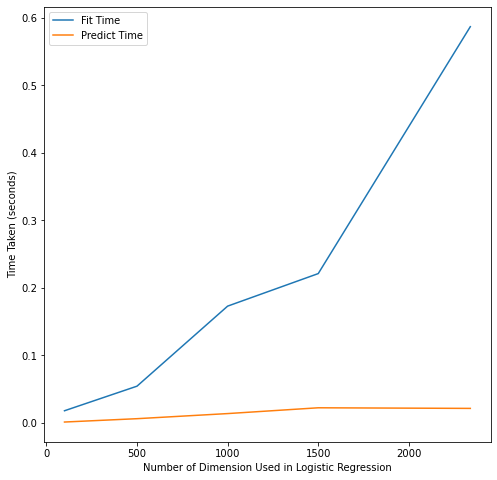

In [1081]:
plt.figure()
sns.lineplot(x=dims, y=lr_pca_models['fit_time'].values, label='Fit Time')
sns.lineplot(x=dims, y=lr_pca_models['predict_time'].values, label='Predict Time')
plt.xlabel("Number of Dimension Used in Logistic Regression")
plt.ylabel("Time Taken (seconds)")
plt.title("Too Many Dimensions Slow Down Logistic Regression")
plt.title("")
plt.legend()
plt.show()


From this we can see that fit time does increase as the number of dimensions increases, though prediction time does not vary as much. This could become an issue with very large datasets.

## Advantages and Disadvantages of Dimensionality Reduction

Dimensionality Reduction is very useful in simplifying modelling. As we have seen, taking the model from 2339 attrbiutes attributes to only 100 had a significant impact on run time. This simplicity is an advantage because, by Occam's Law, we should not use elements beyond what is necessary. Dimensionality reduction is advantageous in that it allows for more distinct models. As discussed, it also can help with issues of overfitting. On the other hand, it removes information from our data that may be useful. For example, there is a chance that performing Dimensionality Reduction on our training data would mean missing out on strong relationships in our testing (or real world) data. This would be the result of having to use a specific set for modelling. 

# K-Nearest Neighbours Classifier <a id=KNN a>

Now we will look into how a KNeighbours Classifier performs on our data. This algorithm focuses on similarity to surrounding data points. It considers the class of a number of nearest 'neighbors' and classifies based on which class the majority of neighbours are in. For this reason the number of neighbours, known as k, is generally chosen to be an odd number, because this ensures no ties in the voting. As the classification is decided by a subset of the whole dataset, at a certain point the classificiations will converge based on which class is the majority of the whole dataset. For this reason, it is not a good idea to pick a k higher than half the dataset size. 

Another important feature of this algorithm is the weight placed on each neighbour when deciding the classification. The neighbours are the k closest data points and the default is to consider all of these with equal importance - this is a 'uniform' weighting. Another option is to place more importance on neighbours that are closer to the data point in question, a 'distance' weighting. It seems intuitive to using the distance weighting, because closer points should be more similar. However, the algorithm is not about which neighbour is closest but rather how a group of points are classified. For this reason, there are cases where a 'uniform' prediction does better. 

This algorithm is heavily based in calculating distances so it is very important that data be scaled before it is used. This is because we want to ensure that it is calculated distances that are not biased by differences in unit size. We will start with a StandardScaler because...

We will begin we a base model, using the default parameters for KNN - 5 neighbours and a uniform weights. Like with logistic regression we have created a function that easily performs iterations of classifications and compares different parameters. However, for our base case we will simply pass in the default values.  

In [1082]:
def knn_pipe(X_train, X_val, y_train, y_val, scalers, ks, weightings):
    """
    Takes in data and a set of parameters for a K Nearest Neighbours classifier and then runs 
    all combinations of the paramters. Training and testing scores are reported, along 
    with individual model parameters, in a dataframe (which is the value returned by the
    function).
    """
    
    knn_mods = pd.DataFrame(columns=[
        'model', 'scaler', 'k', 'weighting', 'train_score', 'val_score'
    ])
    
    # n_jobs
    # looping over scalers to be considered
    for s in scalers:
        # loopoing over weightings to be considered
        for w in weightings:
            # looping over k values to be considered
            for k in ks:
                # initialising steps of the pipelines
                knn_estimators = [('scale', s),
                                ('model', KNeighborsClassifier(n_neighbors=k,
                                                               weights = w))]
                # intialising pipeline
                knn_pipe = Pipeline(knn_estimators, verbose=1)
                # fitting training data to the 
                knn_pipe.fit(X_train, y_train)
                knn_mods = pd.concat([knn_mods, pd.DataFrame({
                    'model': knn_pipe[-1], 
                    'scaler': s,
                    'k': k,
                    'weighting': w,
                    'train_score': [knn_pipe.score(X_train, y_train)],
                    'val_score': [knn_pipe.score(X_val, y_val)]})])

    return knn_mods

In [1083]:
# initialising basic version of our classification
base_knn = knn_pipe(X_train_useful, X_test_useful, y_train, y_test, 
                    scalers=[StandardScaler()], ks=[5], weightings=['uniform'])
base_knn

[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


,model,scaler,k,weighting,train_score,val_score
0,KNeighborsClassifier(),StandardScaler(),5,uniform,0.818157,0.702601


From this output we can see that our base model does not do particularly well. This is to be expected as we have not looked at tuning any of our parameters. The training score is 81.8% and the score on our test set is 70.2%. As a note, the function was written with the consideration that it would use training and validation sets because iterating over the test set so many times is not good practive (as discussed). Therefore, the output say 'val_score' but in this case it is the test score.

Before we look into tuning our parameters we will consider how the size of a dataset impacts the runtime for KNN. Looking into the run-time of KNN is important because the algorithm is based on calculating distances between all points. This is computationally very expensive and should be considered when selecting an appropriate model.

As we are only considering the run-time of the model, we will not evaluate these models, and only look into time taken to fit and predict the training set. (We could look at fitting the testing set, but we are not actually interested in the evaluating). Again, as we are only looking at run times, we will not worry about tuning our parameters and instead use the default version of the model. (We need to keep all things equal to have a true understanding of the difference in run time).

We do need to ensure that our data is scaled, however, so we will do this using a StandardScaler() again. 

We will look at samples of 2000, 4000, 6000, 8000, 10000 and the full training set. This will give us a good view of how the run time varies. As we are not concerned with the model accuracy or ensuring that we have a representative dataset, we will not do random selections but rather take the first n rows from the training and testing, where n is the sample size.

In [1084]:
# list of different size 
samp_size = [2000, 4000, 6000, 8000, 12798]

knn_run_time_fit = []
knn_run_time_predict = []

# time (

for i in range(len(samp_size)):
    
    scaler = StandardScaler()
    X_train_samp_scal = scaler.fit_transform(X_train_useful[0:samp_size[i]])
    
    knn = KNeighborsClassifier()
    
    start_time_fit = time.time()
    knn.fit(X_train_samp_scal, y_train[0:samp_size[i]])
    
    # we use this as the end time for the fitting and the start time for the predicting 
    end_time_fit = time.time()
    knn.predict(X_train_samp_scal)
    
    end_time_predict = time.time()
    
    knn_run_time_fit.append(end_time_fit - start_time_fit)
    knn_run_time_predict.append(end_time_predict - end_time_fit)
    

Now that we have calculated run times for KNN with different values, we can look into this relationship. We expect that as the number of data points used to fit the model increases, run time will also increase.

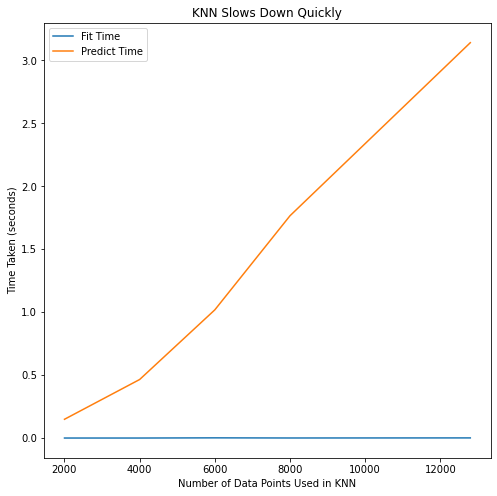

In [1085]:
plt.figure()
sns.lineplot(x=samp_size, y=knn_run_time_fit, label='Fit Time')
sns.lineplot(x=samp_size, y =knn_run_time_predict, label='Predict Time')
plt.xlabel("Number of Data Points Used in KNN")
plt.ylabel("Time Taken (seconds)")
plt.title("KNN Slows Down Quickly")
plt.legend()
plt.show()


The graph above shows us that as we increase the number of data points used in a K Neighbours Classifier, the run time to fit the model increases. 

There are advantages and disadvantages to reducing the number of observations. An advantage is, as we have seen, a reduction in run time. On the other hand, a major disadvantage to reduce our data is that we are limiting ourselves to the inferences that can be made from the subsection. We expose ourselves to more overfitting in smaller datasets. This is an issue that needs to be balanced, but it seems that it makes little sense to reduce accuracy for quicker fit time, especially when the prediction time does not vary much.

Now that we have looked into reducing the number of datapoints we will look into tuning our base model. Before we used the default parameters for sklearn's K Neighbours Classifier and now we will look into altering the number of neighbours and the weights used. As mentioned above, we will not go above half the neighbours in the dataset, but this would still mean looking at over 5000 neighbours for each point. This seems unreasonable logically and computationally, so we will look at using upto 49 neighbours (only the odd numbers). 

As we have been asked to begin using a validation set, we will perform a train test split on the training set. This will give us a subset of our training data to be used in our model validation. As is good practice, we will use a validation set of 20%.  We will also stratify this split so that we get equal class sizes in our training and validation sets.

In [1086]:
# creating training and validation sets for our 
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_useful, y_train, test_size=0.20, 
                                                          random_state=11, stratify=y_train)

We will use our `knn_pipe` function from above with our new training and validation sets. We will only use the StandardScaler as the option for scaling and uniform weights on the neighbours.

In [1087]:
knn_models = knn_pipe(X_train_sub, X_val, y_train_sub, y_val, [StandardScaler()], weightings=['uniform'],
                      ks = list(range(1, 49,2)))

[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
[Pipel

To see which model performed the best we will find the row with the highest validation score, however we will also look at how training and validation score performed with different number of neighbors below.

In [1089]:
knn_models

,model,scaler,k,weighting,train_score,val_score
0,KNeighborsClassifier(n_neighbors=1),StandardScaler(),1,uniform,1.0,0.74977
0,KNeighborsClassifier(n_neighbors=3),StandardScaler(),3,uniform,0.852189,0.736406
0,KNeighborsClassifier(),StandardScaler(),5,uniform,0.810369,0.743318
0,KNeighborsClassifier(n_neighbors=7),StandardScaler(),7,uniform,0.797005,0.746544
0,KNeighborsClassifier(n_neighbors=9),StandardScaler(),9,uniform,0.785484,0.743779
0,KNeighborsClassifier(n_neighbors=11),StandardScaler(),11,uniform,0.779724,0.742396
0,KNeighborsClassifier(n_neighbors=13),StandardScaler(),13,uniform,0.777995,0.748848
0,KNeighborsClassifier(n_neighbors=15),StandardScaler(),15,uniform,0.772465,0.752995
0,KNeighborsClassifier(n_neighbors=17),StandardScaler(),17,uniform,0.770276,0.75023
0,KNeighborsClassifier(n_neighbors=19),StandardScaler(),19,uniform,0.767742,0.752074


In [1090]:
knn_models[knn_models['val_score'] == max(knn_models['val_score'])]

,model,scaler,k,weighting,train_score,val_score
0,KNeighborsClassifier(n_neighbors=15),StandardScaler(),15,uniform,0.772465,0.752995


Though we know that using k=15 gave us the highest validation score, 75.3%, we will visualise how well the model performed with differnt k values. 

/Users/pippidebree/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/pippidebree/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


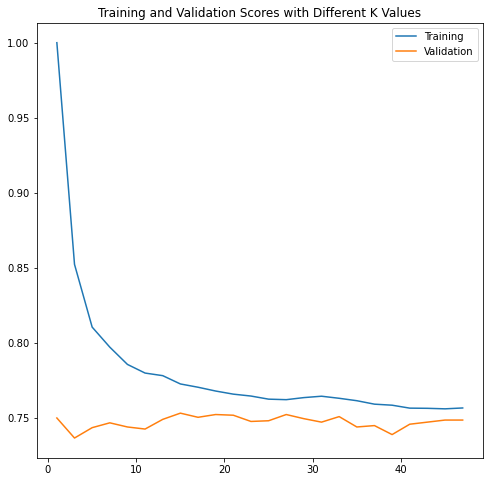

In [1091]:
k_x = list(range(1, 49, 2))

plt.figure()
sns.lineplot(k_x, knn_models['train_score'].values, label='Training')
sns.lineplot(k_x, knn_models['val_score'].values, label='Validation')
plt.title("Training and Validation Scores with Different K Values")
plt.xticks()
plt.show()

Here we can see that the training score drops drastically with more neighbours, but the validation score is fairly consistent. We will conclude that using k=15 is the best choice becasue there is an incline to that point and the training overfitting seems to level at there. 

There is an issue with splitting out training and validation sets like this, after vectorisation, because this means that we have used the data in the validation set to fit our vectorisation. The values in the word matrix, and their prevalence, are impacted by the validation set. This means that our validation set is linked to our model fit and therefore cannot give as unbiased a prediction as possible. 

However, we need to vectorise after splitting to ensure that we have same sized matrices. Ideally, we would fit our vectoriser on the training set and then transform our validation (and testing) sets using the model created by the fit. 

Because we know this is an issue, we will check how our model performed on the test score. We assume that it will do worse on than the validation data. This is based on the assumption that the test set was fit to the vectorisations fit on the training set.

In [1092]:
knn_models.loc[knn_models['k'] == 15]['model'].values[0].score(X_test_useful, y_test)

/Users/pippidebree/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.6140145301148348

As expected, we have a low testing score. This is further explained by KNN models not being well suited to text vectorised data because it is heavily dependent on location data.

# Decision Tree Classifier <a id=Tree a>


We will now begin to look into using a Decision Tree Classifier. This algorithm is based on making a tree of binary decisions which ends with leaves that designated a classification for the data point. The choice of binary decision is optimised by which split in the data would create a group with the highest possible majority of one group. This is known as purity, with a 100% purity meaning one of the choices has 100% of one of the categories. The choice of which decision is made is based on Information Gain, a calculation of the difference in purity from the parent (the group the decision is being made on) to the sum of the purity in the two branches. 


The parameters for a decision tree classifier are max_depth (how many layers the tree can have) and criterion (the formula used to calculate information gain (either Gini or Entropy). We can also use min_samples_leaf to put a lower bound on how many data points each leaf must have in it. This is a measure to reduce overfitting, as if the tree is able to have leaves with only one datapoint, it will be very biased to the intricacies of the training set.

Decision Trees do not need scaling. This is because the decisions made are always dependent on one feature, or dimension, meaning that combinations of features are never made and so the differences in size has no impact. For this reason we will not use unnecessary computational load to create scaled data. 

As before, we will start with a base model which uses the default parameters, which in this case are gini criterion and no max_depth. We could use our train validation split, but in order to compare our base model to the base Logistic Regression and KNN models we will use the same data - the training and testing. Like for the other classifiers, we have create a function that iterates over models with different parameter combinations. In this case the only parameters are depth and info_gain_crierion and we are not scaling, so there is no need for a pipeline. 

In [1093]:
def tree_pipe(X_train, X_test, y_train, y_test, depth, info_gain_criterion):
    """
    Takes in data and a set of parameters for a Decision Tree and then runs 
    all combinations of the paramters. Training and testing scores are reported, along 
    with individual model parameters, in a dataframe (which is the value returned by the
    function)."""
    
    dt_mods = pd.DataFrame(columns=[
        'model', 'max_depth', 'actual_depth', 'criterion', 'train_score', 'val_score'
    ])
    
    
    for d in depth:
        for c in info_gain_criterion:
            dt = DecisionTreeClassifier(max_depth=d, criterion=c)
            dt.fit(X_train, y_train)

            new_mod = {
                'model': [dt],
                'max_depth': [d],
                'actual_depth': [dt.get_depth()],
                'criterion': [c],
                'train_score': [dt.score(X_train, y_train)],
                'val_score': [dt.score(X_test, y_test)]
            }

            dt_mods = pd.concat([dt_mods, pd.DataFrame(new_mod)])
                
    return dt_mods

In [1094]:
base_tree = tree_pipe(X_train_sub, X_val, y_train_sub, y_val, depth=[None], info_gain_criterion=['gini'])
base_tree

,model,max_depth,actual_depth,criterion,train_score,val_score
0,DecisionTreeClassifier(),None,26,gini,1.0,0.750691


Our base model shows overfitting, we can see this in the training score being 100! while the testing score is 76%. This is because the algorithm, without depth limit, was able to create the perfect decision tree for the training data meaning the model is perfectly fit to the training data. Going forward, we will need to put a limit on the max_depth in order to avoid this overfitting. Even though we overfit, our model did better than the KNN, with a test score of 63.7% and a much more reasonable training score of 75.1%.

(As with the `knn_pipe` function, the output says 'val_score' but in this case it is the test score). 

As discussed, the big issue with our base decision tree model was overfitting to the training set. We will now begin looking into how we can maximise our accuracy while limiting our max_depth. We will use the `tree_pipe` function to iterate over different values of max_depth. It is also intereseting to look at the difference in information gain criterion in calculating an optimal tree. In order to just look at the impact of different depths, we will only compare the scores for models built using the same information gain criterion (gini or entropy).

As a note: we could also look at min_samples_leaf to avoid overfitting, as this makes sure that each leaf node has a certain number of data points but we will focus on max_depth here.

We will use a validation set for this optimisation, and can use the train-validation split data from our KNN exploration. 

In order to consider how deep we should make our decision tree, we need to think about how deep it can be. From our base model we can see that the maximum possible depth, of an optimised tree, is 56. In this case there was serious overfitting, and it can be assumed that max_depth values close to this will also show signs of overfitting. Though we can assume that we will not end up with an optimal max_depth near 56, for the sake of understanding where overfitting happens we will look at all max_depth values from 1 to 56.

In [1095]:
# decision tree depths to look at 
depths = list(range(1,20))

# running decision tree classifiers with max depths of 1 to 61, while varying the information gain criterion. 
tree_mods = tree_pipe(X_train_sub, X_val, y_train_sub, y_val, depth=depths, info_gain_criterion=['gini', 'entropy'])

In order to understand the performance of our models, we will plot the differences in the training accuracy against testing accuracy for different max_depth values. 

In [1096]:
tree_mods

,model,max_depth,actual_depth,criterion,train_score,val_score
0,DecisionTreeClassifier(max_depth=1),1,1,gini,0.674309,0.67788
0,"DecisionTreeClassifier(criterion='entropy', ma...",1,1,entropy,0.674309,0.67788
0,DecisionTreeClassifier(max_depth=2),2,2,gini,0.704724,0.689862
0,"DecisionTreeClassifier(criterion='entropy', ma...",2,2,entropy,0.704724,0.689862
0,DecisionTreeClassifier(max_depth=3),3,3,gini,0.721544,0.715668
0,"DecisionTreeClassifier(criterion='entropy', ma...",3,3,entropy,0.711636,0.704147
0,DecisionTreeClassifier(max_depth=4),4,4,gini,0.731567,0.729032
0,"DecisionTreeClassifier(criterion='entropy', ma...",4,4,entropy,0.733756,0.713825
0,DecisionTreeClassifier(max_depth=5),5,5,gini,0.74735,0.72765
0,"DecisionTreeClassifier(criterion='entropy', ma...",5,5,entropy,0.752074,0.729493


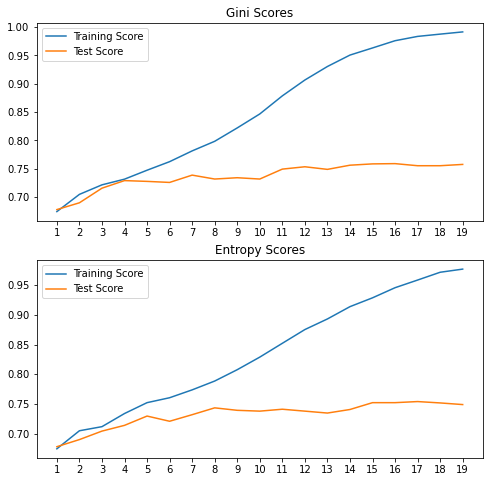

In [1099]:
gridspec.GridSpec(2,1)

plt.subplot2grid((2,1), (0,0))
sns.lineplot(x=depths, y=tree_mods[tree_mods['criterion'] == 'gini']['train_score'].values, label="Training Score")
sns.lineplot(x=depths, y=tree_mods[tree_mods['criterion'] == 'gini']['val_score'].values, label="Test Score")
plt.xticks(depths)
plt.title('Gini Scores')


plt.subplot2grid((2, 1), (1,0))
sns.lineplot(x=depths, y=tree_mods[tree_mods['criterion'] == 'entropy']['train_score'].values, label="Training Score")
sns.lineplot(x=depths, y=tree_mods[tree_mods['criterion'] == 'entropy']['val_score'].values, label="Test Score")
plt.xticks(depths)
plt.title('Entropy Scores')
                 
plt.show()

As expected, we can see that as we let max depth increase, overfitting began and our testing score suffered. It seems that our optimal max_depth is between 5 and 10, but we will find out the exact value.

In [1100]:
# Getting the model with the highest validation score 
tree_mods[tree_mods['val_score'] == max(tree_mods['val_score'])]

,model,max_depth,actual_depth,criterion,train_score,val_score
0,DecisionTreeClassifier(max_depth=16),16,16,gini,0.975922,0.758986


From this we can see that our optimal Decision Tree Classifier, based solely on validation score has a depth of 16. However, we can see that this model has a very high training score (meaning overfitting). Because of this we will look at the model that has the most similar training and validation scores. 

In [1101]:
# Getting the model with the closest training and validation scores 
opt_tree = tree_mods[(abs(tree_mods['train_score'] - tree_mods['val_score'])) == 
          (min(abs(tree_mods['train_score'] - tree_mods['val_score'])))]
opt_tree

,model,max_depth,actual_depth,criterion,train_score,val_score
0,DecisionTreeClassifier(max_depth=4),4,4,gini,0.731567,0.729032


Though it could be argued to use a slightly larger max_depth, using a depth of 4 seems to ensure that we are minimise our overfitting as much as possible while getting good validations. We are not confident in the ability of this model to work with our test data because we know that it is very prone to overfitting. We will check this assumption. 

In [1102]:
opt_tree['model'].values[0].score(X_test_useful, y_test)

0.6990860089055543

Again, this is an expected decrease accuracy when we test our model on unseen data. Though we are not confident in our decision tree, we will visualise it in order to get a better understanding.

To visualise our optimised decision tree we will 

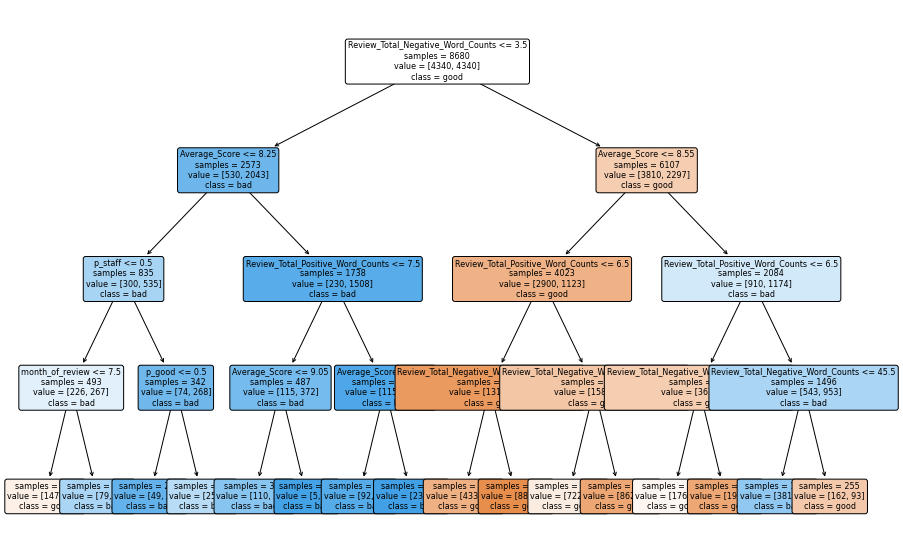

In [1106]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tree(opt_tree.iloc[0].values[0], 
          feature_names=X_train_useful.columns, 
          class_names=["good", "bad"],
          rounded=True,
          impurity=False, # set true to see the gini (or criterion) score
          filled=True,
         fontsize=8);

Considering when to use which model is very dependent on domain, but there are some overall advantages and disadvantages to each model. Comparing Decision Trees to KNN, Decision Trees are simpler to understand. KNN is a computationally expensive model, as distances need to be calculated between every data point. KNN is heavily reliant on the dimensional 'location' context of the data, and this means that they are not well suited to text vectorised data because these binary attributes have less dimensional nuiance. 

However, as we have seen, Decision Trees are very sensitive to the data and therefore overfitting. We saw that as max depth is allowed to increase, the model gets more and more specific. This is an issue because it means that intricacies in the data can be over emphasized, leading to biases towards training data. Though we have considered Decision Trees for Classification, they can also be used with Regression (where the predicted value is the average of the leaf node). One weakness of doing this is that these predictions cannot go beyond the range of the training data, causing serious limitations. 

# Why Do We Validate? <a id=Valid a>

Inherent in finding a good model is testing how well different versions of the same models do. For this reason we use data that has not been used in fitting the model to evaluate. As mentioned before beginning our modelling, so far we have been using our testing set to evaluate our base models. However, we have been using a subsetion of the training data when tuning our models. This is because evaluating many iterations of our models with the actual testing data would lead to issues of overfitting to the testing set (in other words we would be prone to anomalies in the test set impacting our choice of the best model. 

In order to have a true understanding of our chosen model's success we need to present it with unseen data and evaluate how well it does. If we use our testing data continuously through our modelling process, we tailor this choice to the test set. For this reason, we have been using what is known as a validation set to evaluate the iterations of our models. However, we have still been exposing ourselves to overfitting because our evaluations have always been based on this same subset. Using a validation dataset once could lead to the same issues as using a test set - we risk overfitting to the validation set in our model selection as we are prone to being over-influenced by eccentricities in the validation set. 

To combat this, we employ Cross Validation. This technique involves using a number of different validation sets, taken from the training set, on the same model. The results of these different model fits are then averaged and this is taken as the accuracy of the model. The number of validation sets directly impacts the size of these subsets, as every data point will be used as part of the validation in one of the iterations (known as folds). For example, if we choose to do 4 folds of cross validation, the dataset will be split into 4, with one distinct quarter being used as the validation in each of the folds. Therefore using 4 folds would result in validation sets of 25%, of the total training set. 

General practice is to use 5 folds, meaning a 20% validation set. We will now implement Cross Validation in our model selection. 

# Cross Validating A Logistic Regression Classifier <a id=Cross a>


Now that we have explored the options of our dataset we will return to our Logistic Regression because this is the model that performed best in our exploration. Also, in our optimisation of Decision Tree maximum depth we saw that trying to make the model perform better for validation data lead to overfitting. 

After concluding that we should perform cross validation on our modelling we will implement sklearn's `GridSearchCV` in order to find the optimal parameters for our model. This model selection implements cross validation on the data passed in with the number of folds being, as default, five (this can be changed with the `cv` parameter). GridSearchCV performs cross validation by taking a grid of parameters to be looked at and fitting each combination in the model k-times, where k is the number of folds in the cross validation. Model accuracies are then reported for every fold, but means accross the folds can be accessed in order to compare different parameters. 

Though we were limited in our initial exploration of Logistic Regression we will now look further into how we can tune this model to get the best possible fit. This will include using different solvers and penalties.

`GridSearchCV` is built on top of Pipeline functionality, so the grid passed to it is essentially a grid of estimators (as would be passed to a pipeline). In order to get our best possible model, we will broaden our search. We assume that we will use all 56 attributes in our `X_train_useful` set, but we will look into using PCA to optimise these. Therefore we need to scale our model. So far we have only used the StandardScaler, but now will add in MinMaxScaler to see if it performs better (though we expect it not to). (It seems that StandardScaler would be better suited with PCA because it considers variance, and PCA is rooted in exploring variances). 

The parameters we will be tuning are:
- Scaling: StandardScaler or MinMaxScaler (we cannot try no scaler)
- Dimensionality Reduciton: PCA with number of components from 0 to 56. 
- Weight on Coefficient Values: C ranging from 0.0001 to 10000 (intervals of times 10)
- Penalty: Lasso or Ridge Regression ('l1' or 'l2')

Because we want to comparing using l1 and l2 penalties, we will use a saga solver (which can work with either, unlike lbfgs). 

In [1107]:
# The steps of the pipe within our gridsearch 
dt_estimators = [('scale', StandardScaler()),
                 ('dim_red', PCA()),
                 ('model', LogisticRegression())]

# initialising the pipeline for our gridsearch
dt_pipe = Pipeline(dt_estimators)

# parameters to be tested in our gridsearch 
dt_param_grid = [{'scale': [StandardScaler()],
                  'dim_red__n_components':list(range(1,57)),
                  'model__max_iter': [2000],
                  'model__C': [10**x for x in range(-4,5)],
                  'model__solver': ['saga'],
                  'model__penalty': ['l1', 'l2']
                 }]


dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=5, verbose=2, n_jobs=-1)

In [1108]:
dt_grid.fit(X_train_useful, y_train)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.01, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END 

[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.01, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.01, model__max_iter=2000, mod

[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.01, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=1, model__C=0.01, model__max_iter=2000, mode

[CV] END dim_red__n_components=8, model__C=1, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=1, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=10, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=10, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=100, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=100, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=8, model__C=1000, model__max_iter=2000, model__penalty=l1, mode

[CV] END dim_red__n_components=17, model__C=0.01, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=0.1, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=0.1, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=1, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=1, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=1, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=17, model__C=1, model__max_iter=2000, model__penalty=l2,

[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, 

[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=1000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=20

[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.01, model__max_iter=20

[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=19, model__C=10000, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=20, model__C=0.0001, model__max_iter=2000, model__penalty=l2, model__solver=saga, scale=StandardScaler(); total time=   0.1s
[CV] END dim_red__n_components=20, model__C=0.001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.001, model__max_iter=2000, model__penalty=l1, model__solver=saga, scale=StandardScaler(); total time=   0.2s
[CV] END dim_red__n_components=20, model__C=0.01, model__max_iter=20

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('dim_red', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'dim_red__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29, 30, ...],
                          'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                       1000, 10000],
                          'model__max_iter': [2000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['saga'],
                          'scale': [StandardScaler()]}],
             verbose=2)

In [1109]:
# finding the best model 
dt_grid.best_estimator_

Pipeline(steps=[('scale', StandardScaler()), ('dim_red', PCA(n_components=55)),
                ('model',
                 LogisticRegression(C=0.1, max_iter=2000, solver='saga'))])

In [1110]:
# finding the best validation score
dt_grid.best_score_

0.7678341013824885

From our GridSearch we can see that the best possible model uses a StandardScaler, all of the compoenents except one, a C value of 0.1 (meaning bigger penalties on large coefficients). This result is based entirely on the training set (though split into different validations). We will now check it with our test set.

In [1111]:
dt_grid.score(X_test_useful, y_test)

0.7604874619170378

This is a good result! Our test set performs almost as well as our validation set. This means that the model we have built is not too influenced by overfitting. We will check where our model is having issues by looking at the confusion matrix. This will allow us to see whether our model is mis-categorising the good reviews as bad or the inverse. 

In [153]:
y_preds = dt_grid.predict(X_test_useful)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_preds)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Bad Review", "Predicted Good Review"],
    index=["True Bad Review", "True Good Review"]
)

display(cf_df)

NameError: name 'dt_grid' is not defined

/Users/pippidebree/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

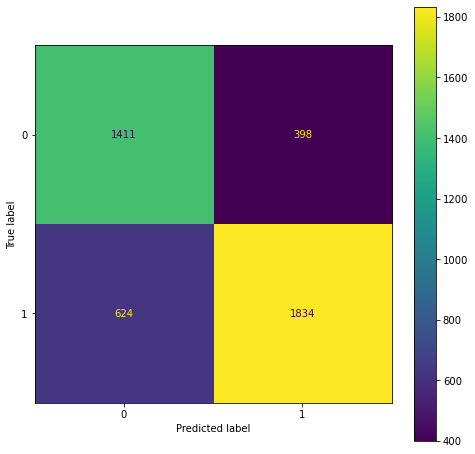

In [1114]:
plt.figure()
plot_confusion_matrix(dt_grid, X_test_useful, y_test)
plt.show()

From our confusion matrix we can see that we have more of an issue with false negative than false positive. 

# New Feature Creation <a id=Feature a>

A new feature that may be helpful in our modelling may be a measure of the difference in number of words in the positive review vs the negative review. In general, people have more to say about the thing they feel strongly about, so either that is was a good hotel or that is was a bad hotel. Intuitively, it seems unlikely that a person would write a negative review and then write an equal length positive review. For this reason we will create a variable call `proportion_positive_words`, which takes the proportion of total words in the positive and negative review and expresses what percentage were spent on the positive review. 

Using proportions, instead of total word count, also normalises against difference in how many words people use when writing reviews. There may be reviewers who are very succint and those who are write with detail. The differences in these writers may skew our model, as length may conflated with sentiment, not individual style. We may have seen issues with this in our decision tree, where `Review_Total_Positive_Word_Counts` was very important. 

Inherent in this new variable is proportion of negative words, so this variable does not need to be created. 

In [1115]:
# Initialising new dataset to which we will add the new feature.
X_train_new = X_train_useful
X_test_new = X_test_useful

In [1116]:
# creating proportion positive length
X_train_new['proportion_positive_words'] = X_train_useful['Review_Total_Positive_Word_Counts'] / (
    X_train_useful['Review_Total_Negative_Word_Counts'] + X_train_useful['Review_Total_Positive_Word_Counts'])

X_test_new['proportion_positive_words'] = X_test_useful['Review_Total_Positive_Word_Counts'] / (
    X_test_useful['Review_Total_Negative_Word_Counts'] + X_test_useful['Review_Total_Positive_Word_Counts'])


The one worry with this calculation is cases where there are zero values for both the `Review_Total_Positive_Word_Counts` and `Review_Total_Negtive_Word_Counts`. This would create infinite values and if, after changing to 0, they were included would be misrepresentative. (If both are 0 and the value for the column is 0, this suggest that this is a case a of reviewer not writing any positive words, only negative - but in reality they wrote neither). For this reason we will drop these NaN rows. Before doing so we will double check that no other rows have missing values.

In [1117]:
X_train_new.isna().sum()

Additional_Number_of_Scoring                  0
Average_Score                                 0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
days_since_review                             0
lat                                           0
lng                                           0
weekday_of_review                             0
month_of_review                               0
year_of_review                                0
trip_leisure                                  0
trip_biz                                      0
group_couple                                  0
p_bed                                         0
p_breakfast                                   0
p_clean                                       0
p_comfortable                                 0
p_comfy                                       0
p_excellent                             

As there are only four rows we are not worried about the impact that dropping these rows has on the class equality of `good_review`. We will not look into the number of these cases in the test set but instead drop them directly. 

In [1118]:
train_na_index = X_train_useful[X_train_useful['proportion_positive_words'].isna()==True].index.values
test_na_index = X_test_useful[X_test_useful['proportion_positive_words'].isna()==True].index.values

As a safety measure, instead of using `dropna` we will use `drop` and pass in the indexes to drop. This will ensure that the same rows are removed from our X and y tables for the training and testing sets. 

In [1119]:
# Dropping the rows with missing data from the X and y 
X_train_new = X_train_new.drop(index=train_na_index)
X_test_new = X_test_new.drop(index=test_na_index)

y_train_new  = y_train.drop(index=train_na_index)
y_test_new = y_test.drop(index=test_na_index)

Here we see a fairly good distribution, implying that the different values will be representated. 

In order to cross validate, we will use the parameters from our GridSearch again. We need to reinstantiate the models to find the best because we have a new training set, with a different size. It cannot be assumed that the same model would perform the best. As we already have the estimators and pipeline set up, we only need to restart the grid search and fit the new training set. 

In [1120]:
dt_grid_new = GridSearchCV(dt_pipe, dt_param_grid, cv=5, verbose=1, n_jobs=-1)
dt_grid_new.fit(X_train_new, y_train_new)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('dim_red', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'dim_red__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15, 16,
                                                    17, 18, 19, 20, 21, 22, 23,
                                                    24, 25, 26, 27, 28, 29, 30, ...],
                          'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                       1000, 10000],
                          'model__max_iter': [2000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['saga'],
                          'scale': [StandardScaler()]}],
             verbose=1)

In [1121]:
# finding the best model 
dt_grid_new.best_estimator_

Pipeline(steps=[('scale', StandardScaler()), ('dim_red', PCA(n_components=53)),
                ('model',
                 LogisticRegression(C=0.01, max_iter=2000, solver='saga'))])

In [1122]:
dt_grid_new.best_score_

0.7692246634075037

Our optimised parameters are slightly different from before! We have reduced our dimensions by 3 dimensions and have put more emphasis on reducing the size of large coefficients (C has gone from 0.1 to 0.01). Our mean validation score does pretty well, at almost 77%

Again, it is important that we evaluate the success of our model by looking at how the test set performs on the model.

In [1123]:
dt_grid_new.score(X_test_new, y_test_new)

0.7630653855167565

Though slight, this is an improvement (from 76.0% to 76.3%!) We will again look at where the model has problems by checking our confusion matrix.

In [1124]:
y_preds_new = dt_grid_new.predict(X_test_new)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test_new, y_preds_new)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Bad Review", "Predicted Good Review"],
    index=["True Bad Review", "True Good Review"]
)

display(cf_df)

,Predicted Bad Rating,Predicted Good Rating
True Bad Rating,1415,394
True Good Rating,617,1841


/Users/pippidebree/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 576x576 with 0 Axes>

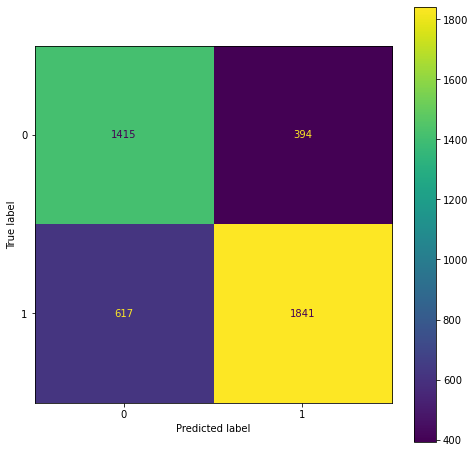

In [1125]:
plt.figure()
plot_confusion_matrix(dt_grid_new, X_test_new, y_test_new)
plt.show()

Similarly to before, we still have an issue of many false negatives (with some false positives). 

# Conclusion <a id=Conclu a>

This exploration of modeling hotel ratings given by hotel guest has considered three main classification algorithms. Looking at a K Nearest Neighbours Classifier exposed how poorly suited it is at working with vectorised or encoded data. This is an issue in the algorithm’s construction, as it is heavily based on calculating distances and finding similar points. Applying this to data with many binary attributes creates issues, as the lack of dimensional nuance means that the idea of nearness is not as clear. 

When we considered using a Decision Tree the greatest issue was overfitting. This model, without tuning, can be overly specific to training data as it is allowed to create decisions that perfectly classify the data. However, when we limited the maximum depth, to combat overfitting, we found that we could not build a tree large enough to classify well without overfitting. 

Overall, using a Logistic Regression is best suited to this dataset. We found that our optimal model is a Logistic Regression, scaled using the Standard Scaler, using 53 of our features and with a value for C of 0.01. 